# Simulation fo the behaviour of the call center model with service delay

Short version simplified as:

$$X[k+1] = X[k] + d[k] - s[k] - a[k]$$

In [ ]:
using Random
using DelimitedFiles
using PrettyTables

using Plots
using LaTeXStrings

# Parameters
horiz = 20           # total horizon
n_ser = 2            # number of servers
XM = 10              # max queue length before dropping calls
t = 1:horiz

d_fn = "..//CC_simple//d_mat_Thu_22_May_2025_19_39_50.txt";
a_fn = "..//CC_simple//a_mat_Thu_22_May_2025_19_39_50.txt";

d_mat = DelimitedFiles.readdlm(d_fn);
a_mat = DelimitedFiles.readdlm(a_fn);

d = d_mat[1:horiz, 1];  # demand matrix for incoming calls
a = a_mat[1:horiz, 1];  # abandonment matrix for calls

In [6]:
function printTable(data, header)
    println("Results")
    pretty_table(data; header=header,formatters=ft_printf("%5.3f",1:11))
end


function plotData(evolution, ylabel, title)
    gr()
    plot(evolution, layout = 4, seriestype=:scatter, label=false,xlabel=[L"k" L"k" L"k" L"k"],ylabel=ylabel, title=title,
        palette=cgrad.([:grays :blues :heat :lightrainbow]), bg_inside=[:lightblue :lightblue :lightblue :lightblue])
end

plotData (generic function with 1 method)

## Short version original problem

In [3]:
# State variables
X = zeros(Int, horiz+1)     # current number of customers in queue x(k)
s = zeros(Int, horiz+1)     # number of served customers per timestep
dr = zeros(Int, horiz)      # dropped due to full buffer
z = zeros(Int, horiz+1)     # custumers served

X[1] = 3  # initial state
s[1] = n_ser
z[1] = 0


for k in 1:horiz
    X[k+1] = X[k] + d[k] - s[k] - a[k]

    # If queue exceeds max length, drop excess
    if X[k+1] > XM
        dr[k] = X[k+1] - XM  # dropped calls due to full queue
        X[k+1] = XM
    else
        dr[k] = 0
    end
    
    z[k+1] = z[k] + s[k]
    # Serve up to number of servers
    s[k+1] = min(X[k], n_ser)
end

In [ ]:
data = hcat(t, X[1:horiz,1], s[1:horiz,1], dr, d_mat[:,1], a_mat[:,1])
header = (["t", "X", "s", "dr", "d_mat", "a_mat"])

printTable(data, header)

Results
┌────────┬────────┬───────┬────────┬────────┬───────┐
│      t │      X │     s │     dr │  d_mat │ a_mat │
├────────┼────────┼───────┼────────┼────────┼───────┤
│  1.000 │  3.000 │ 2.000 │  0.000 │  7.000 │ 0.000 │
│  2.000 │  8.000 │ 2.000 │  0.000 │  3.000 │ 1.000 │
│  3.000 │  8.000 │ 2.000 │  0.000 │  3.000 │ 2.000 │
│  4.000 │  7.000 │ 2.000 │  1.000 │  7.000 │ 1.000 │
│  5.000 │ 10.000 │ 2.000 │  9.000 │ 12.000 │ 1.000 │
│  6.000 │ 10.000 │ 2.000 │  5.000 │  9.000 │ 2.000 │
│  7.000 │ 10.000 │ 2.000 │  3.000 │  6.000 │ 1.000 │
│  8.000 │ 10.000 │ 2.000 │  0.000 │  3.000 │ 1.000 │
│  9.000 │ 10.000 │ 2.000 │  0.000 │  0.000 │ 1.000 │
│ 10.000 │  7.000 │ 2.000 │  3.000 │  9.000 │ 1.000 │
│ 11.000 │ 10.000 │ 2.000 │  8.000 │ 11.000 │ 1.000 │
│ 12.000 │ 10.000 │ 2.000 │  9.000 │ 12.000 │ 1.000 │
│ 13.000 │ 10.000 │ 2.000 │  8.000 │ 12.000 │ 2.000 │
│ 14.000 │ 10.000 │ 2.000 │  8.000 │ 12.000 │ 2.000 │
│ 15.000 │ 10.000 │ 2.000 │  0.000 │  2.000 │ 0.000 │
│ 16.000 │ 10.000 │ 

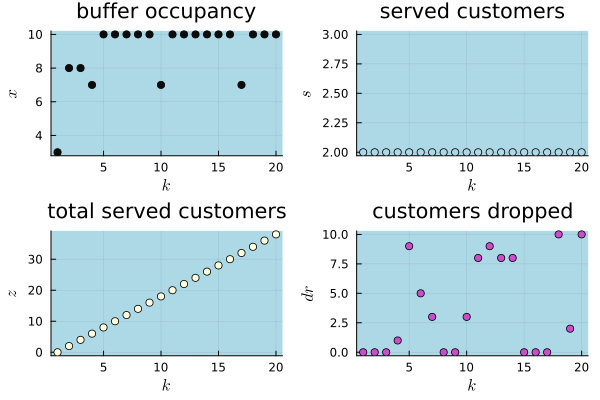

In [ ]:
evolution = [X[1:horiz,1], s[1:horiz,1], z[1:horiz,1], dr]
ylabel = [L"x" L"s" L"z" L"dr"]
title = ["buffer occupancy" "served customers" "total served customers" "customers dropped"]

plotData(evolution, ylabel, title)

## Short version with delay

Version based on the model proposed in 28/05.

In [8]:
# State variables
X = zeros(Int, horiz+1)     # current number of customers in queue x(k)
s = zeros(Int, horiz+1)     # number of served customers per timestep
dr = zeros(Int, horiz)      # dropped due to full buffer
z = zeros(Int, horiz+1)     # custumers served

X[1] = 3  # initial state
s[1] = 0
z[1] = 0

# Servers
t_ser = 4 # time to serve one customer 
st_ser = zeros(Int, n_ser) # state of servers
conv_ser = zeros(n_ser, t_ser) # servers conveyor

for k in 1:horiz

    for i in 1:n_ser
        conv_ser[i, 2:t_ser] = conv_ser[i, 1:t_ser-1] # shift the state of server i
        st_ser[i] = conv_ser[i, 1] # get the state of server i

        # If server is free, start serving a customer
        if st_ser[i] == 0 && X[k] > 0
            s[k] += 1
            conv_ser[i, 1] = 1
        else 
            conv_ser[i, 1] = 0
        end
    end

    X[k+1] = X[k] + d[k] - s[k] -a[k]

    # If queue exceeds max length, drop excess
    if X[k+1] > XM
        dr[k] = X[k+1] - XM  # dropped calls due to full queue
        X[k+1] = XM
    else
        dr[k] = 0
    end

    # Served custumers counted only after the service time
    if k <= t_ser
        z[k+1] = 0
    else
        z[k+1] = z[k] + s[k-t_ser]
    end

end

In [9]:
data = hcat(t, X[1:horiz,1], s[1:horiz,1], dr, z[1:horiz,1], d_mat[:,1], a_mat[:,1])
header = (["t", "X", "s", "dr", "z", "d_mat", "a_mat"]);
printTable(data, header)

Results
┌────────┬────────┬───────┬────────┬────────┬────────┬───────┐
│      t │      X │     s │     dr │      z │  d_mat │ a_mat │
├────────┼────────┼───────┼────────┼────────┼────────┼───────┤
│  1.000 │  3.000 │ 2.000 │  0.000 │  0.000 │  7.000 │ 0.000 │
│  2.000 │  8.000 │ 0.000 │  0.000 │  0.000 │  3.000 │ 1.000 │
│  3.000 │ 10.000 │ 2.000 │  0.000 │  0.000 │  3.000 │ 2.000 │
│  4.000 │  9.000 │ 0.000 │  5.000 │  0.000 │  7.000 │ 1.000 │
│  5.000 │ 10.000 │ 2.000 │  9.000 │  0.000 │ 12.000 │ 1.000 │
│  6.000 │ 10.000 │ 0.000 │  7.000 │  2.000 │  9.000 │ 2.000 │
│  7.000 │ 10.000 │ 2.000 │  3.000 │  2.000 │  6.000 │ 1.000 │
│  8.000 │ 10.000 │ 0.000 │  2.000 │  4.000 │  3.000 │ 1.000 │
│  9.000 │ 10.000 │ 2.000 │  0.000 │  4.000 │  0.000 │ 1.000 │
│ 10.000 │  7.000 │ 0.000 │  5.000 │  6.000 │  9.000 │ 1.000 │
│ 11.000 │ 10.000 │ 2.000 │  8.000 │  6.000 │ 11.000 │ 1.000 │
│ 12.000 │ 10.000 │ 0.000 │ 11.000 │  8.000 │ 12.000 │ 1.000 │
│ 13.000 │ 10.000 │ 2.000 │  8.000 │  8.000 │ 1

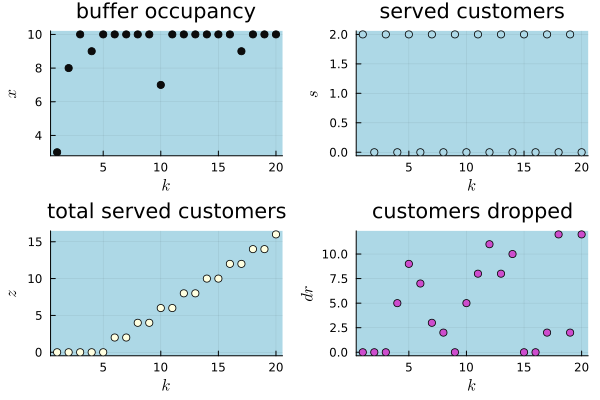

In [10]:
evolution = [X[1:horiz,1], s[1:horiz,1], z[1:horiz,1], dr]
ylabel = [L"x" L"s" L"z" L"dr"]
title = ["buffer occupancy" "served customers" "total served customers" "customers dropped"]

plotData(evolution, ylabel, title)

## Short version with delay and server ocupied 
A new client can only enter the server after the previous one has been served.

In [12]:
# State variables
X_dl = zeros(Int, horiz+1)     # current number of customers in queue x(k)
s_dl = zeros(Int, horiz)       # number of customers entering server per timestep
s_end = zeros(Int, horiz)      # number of served customers per timestep
dr_dl = zeros(Int, horiz)      # dropped due to full buffer
z_dl = zeros(Int, horiz+1)     # custumers served

X_dl[1] = 3  # initial state
s_dl[1] = 0
z_dl[1] = 0

# Servers
t_ser = [2, 3] # delay to serve one customer on
t_serM = 1 + maximum(t_ser) # max time to serve one customer


### Version 0: st_ser is bool. Using conveyor logic ###
st_ser = zeros(n_ser, horiz+1) # state of servers, where 0 means free and > 1 means busy
conv_ser = zeros(n_ser, t_serM) # servers conveyor

for k in 1:horiz
    for i in 1:n_ser
        
        conv_ser[i, 2:t_serM] = conv_ser[i, 1:t_serM-1] # shift the state of server i
        conv_ser[i, 1] = 0 # reset the first element of conveyor
        
        st_ser[i, k] = sum(conv_ser[i, :]) 
        # If server is free, start serving a customer
        if st_ser[i, k] == 0 && X_dl[k] > 0
            s_dl[k] += 1
            conv_ser[i, t_serM-t_ser[i]] = 1
        end
        if st_ser[i, k] == 0 && k > 1 
            s_end[k] += 1
        end
    end

#### Version 1: st_ser is an int. No conveyor ###
# st_ser = zeros(n_ser, horiz+1) # state of servers, where 0 means free and > 0 means busy with remaining time
# for k in 1:horiz

#     for i in 1:n_ser

#         # If server is free, start serving a customer
#         if st_ser[i, k] == 0 && X_dl[k] > 0
#             s_dl[k] += 1
#             st_ser[i, k+1] = t_ser[i]

#             if k > 1 
#                 s_end[k] += 1
#             end
#         else 
#             st_ser[i, k+1] = st_ser[i, k] - 1  # decrement the remaining service time
#         end
#     end

    X_dl[k+1] = X_dl[k] + d[k] - s_dl[k] -a[k]

    # If queue exceeds max length, drop excess
    if X_dl[k+1] > XM
        dr_dl[k] = X_dl[k+1] - XM  # dropped calls due to full queue
        X_dl[k+1] = XM
    else
        dr_dl[k] = 0
    end
        
    z_dl[k+1] = z_dl[k] + s_end[k]
end

In [13]:
data = hcat(t, X_dl[1:horiz,1], s_dl[1:horiz,1], s_end, st_ser[1, 1:horiz], st_ser[2, 1:horiz],  dr, z_dl[1:horiz,1], d_mat[:,1], a_mat[:,1])
header = (["t", "X_dl", "s_dl", "s_end", "st_ser1", "st_ser2", "dr", "z_dl", "d_mat", "a_mat"]);
printTable(data, header)

Results
┌────────┬────────┬───────┬───────┬─────────┬─────────┬────────┬────────┬────────┬───────┐
│      t │   X_dl │  s_dl │ s_end │ st_ser1 │ st_ser2 │     dr │   z_dl │  d_mat │ a_mat │
├────────┼────────┼───────┼───────┼─────────┼─────────┼────────┼────────┼────────┼───────┤
│  1.000 │  3.000 │ 2.000 │ 0.000 │   0.000 │   0.000 │  0.000 │  0.000 │  7.000 │ 0.000 │
│  2.000 │  8.000 │ 0.000 │ 0.000 │   1.000 │   1.000 │  0.000 │  0.000 │  3.000 │ 1.000 │
│  3.000 │ 10.000 │ 0.000 │ 0.000 │   1.000 │   1.000 │  0.000 │  0.000 │  3.000 │ 2.000 │
│  4.000 │ 10.000 │ 1.000 │ 1.000 │   0.000 │   1.000 │  5.000 │  0.000 │  7.000 │ 1.000 │
│  5.000 │ 10.000 │ 1.000 │ 1.000 │   1.000 │   0.000 │  9.000 │  1.000 │ 12.000 │ 1.000 │
│  6.000 │ 10.000 │ 0.000 │ 0.000 │   1.000 │   1.000 │  7.000 │  2.000 │  9.000 │ 2.000 │
│  7.000 │ 10.000 │ 1.000 │ 1.000 │   0.000 │   1.000 │  3.000 │  2.000 │  6.000 │ 1.000 │
│  8.000 │ 10.000 │ 0.000 │ 0.000 │   1.000 │   1.000 │  2.000 │  3.000 │  3.000 │

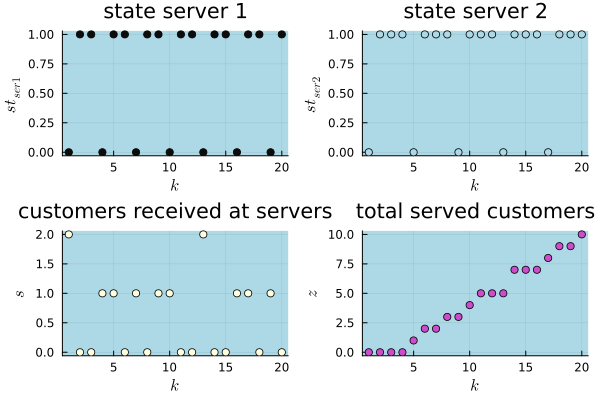

In [ ]:
evolution = [st_ser[1, 1:horiz], st_ser[2, 1:horiz], s_dl[1:horiz,1], z_dl[1:horiz,1]]
ylabel = [L"st_{ser1}" L"st_{ser2}" L"s" L"z"]
title = s["state server 1" "state server 2" "customers received at servers" "total served customers"]

plotData(evolution, ylabel, title)

## Multiple entry points to conveyor

A new client can only enter the server after the previous one has been served.
The service time is variable and is represend as the random conveyor entry point. 

In [15]:
# State variables
X_dl = zeros(Int, horiz+1)     # current number of customers in queue x(k)
s_dl = zeros(Int, horiz+1)     # number of customers entering server per timestep
s_end = zeros(Int, horiz)      # number of served customers per timestep
dr_dl = zeros(Int, horiz)      # dropped due to full buffer
z_dl = zeros(Int, horiz+1)     # custumers served

X_dl[1] = 3  # initial state
s_dl[1] = 0
z_dl[1] = 0

# Servers
t_serM = 4 # maximum time to serve one customer 
st_ser = zeros(n_ser, horiz+1) # state of servers
conv_ser = zeros(n_ser, t_serM) # servers conveyor


for k in 1:horiz
    for i in 1:n_ser
        
        conv_ser[i, 2:t_serM] = conv_ser[i, 1:t_serM-1] # shift the state of server i
        conv_ser[i, 1] = 0 # reset the first element of conveyor

        st_ser[i, k] = sum(conv_ser[i, :]) 
        # If server is free, start serving a customer
        if st_ser[i, k] == 0 && X_dl[k] > 0
            s_dl[k] += 1
            t_ser = rand(1:t_serM-1)  # randomly choose the service time for the server
            # println("k: $k, i: $i, t_ser: $t_ser")
            conv_ser[i, t_serM-t_ser] = 1
        end
        if st_ser[i, k] == 0 && k > 1 
            s_end[k] += 1
        end
    end


    X_dl[k+1] = X_dl[k] + d[k] - s_dl[k] -a[k]

    # If queue exceeds max length, drop excess
    if X_dl[k+1] > XM
        dr_dl[k] = X_dl[k+1] - XM  # dropped calls due to full queue
        X_dl[k+1] = XM
    else
        dr_dl[k] = 0
    end

    # Served custumers counted only after the service time
    z_dl[k+1] = z_dl[k] + s_end[k]

end

In [16]:
data = hcat(t, X_dl[1:horiz,1], s_dl[1:horiz,1], s_end, st_ser[1, 1:horiz], st_ser[2, 1:horiz],  dr, z_dl[1:horiz,1], d_mat[:,1], a_mat[:,1])
header = (["t", "X_dl", "s_dl", "s_end", "st_ser1", "st_ser2", "dr", "z_dl", "d_mat", "a_mat"]);
printTable(data, header)

Results
┌────────┬────────┬───────┬───────┬─────────┬─────────┬────────┬────────┬────────┬───────┐
│      t │   X_dl │  s_dl │ s_end │ st_ser1 │ st_ser2 │     dr │   z_dl │  d_mat │ a_mat │
├────────┼────────┼───────┼───────┼─────────┼─────────┼────────┼────────┼────────┼───────┤
│  1.000 │  3.000 │ 2.000 │ 0.000 │   0.000 │   0.000 │  0.000 │  0.000 │  7.000 │ 0.000 │
│  2.000 │  8.000 │ 0.000 │ 0.000 │   1.000 │   1.000 │  0.000 │  0.000 │  3.000 │ 1.000 │
│  3.000 │ 10.000 │ 0.000 │ 0.000 │   1.000 │   1.000 │  0.000 │  0.000 │  3.000 │ 2.000 │
│  4.000 │ 10.000 │ 1.000 │ 1.000 │   0.000 │   1.000 │  5.000 │  0.000 │  7.000 │ 1.000 │
│  5.000 │ 10.000 │ 1.000 │ 1.000 │   1.000 │   0.000 │  9.000 │  1.000 │ 12.000 │ 1.000 │
│  6.000 │ 10.000 │ 0.000 │ 0.000 │   1.000 │   1.000 │  7.000 │  2.000 │  9.000 │ 2.000 │
│  7.000 │ 10.000 │ 1.000 │ 1.000 │   0.000 │   1.000 │  3.000 │  2.000 │  6.000 │ 1.000 │
│  8.000 │ 10.000 │ 0.000 │ 0.000 │   1.000 │   1.000 │  2.000 │  3.000 │  3.000 │

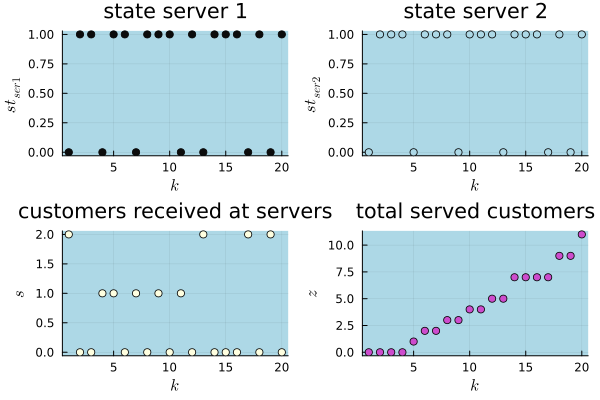

In [ ]:
evolution = [st_ser[1, 1:horiz], st_ser[2, 1:horiz], s_dl[1:horiz,1], z_dl[1:horiz,1]]
ylabel = [L"st_{ser1}" L"st_{ser2}" L"s" L"z"]
title = ["state server 1" "state server 2" "customers received at servers" "total served customers"]

plotData(evolution, ylabel, title)

## Multiple entry points to conveyor and multiple clients on the same server

Version based on the model proposed in 31/05.
The service time is variable and is represend as the random conveyor entry point. 

In [18]:
function P(t_serM, conv_ser_i)
    found_slot = false
    
    while !found_slot
        t_ser = rand(1:t_serM-1)  # randomly choose the service time for the server

        if conv_ser_i[t_serM-t_ser] == 0
            conv_ser_i[t_serM-t_ser] = 1
            found_slot = true 
        end
    end

    return conv_ser_i
end

P (generic function with 1 method)

In [19]:
# State variables
X_dl = zeros(Int, horiz+1)     # current number of customers in queue x(k)
s_dl = zeros(Int, horiz+1)     # number of customers entering server per timestep
s_end = zeros(Int, horiz+1)    # number of served customers per timestep
dr_dl = zeros(Int, horiz)      # dropped due to full buffer
z_dl = zeros(Int, horiz+1)     # custumers served

X_dl[1] = 3  # initial state
s_dl[1] = 0
z_dl[1] = 0

# Servers
t_serM = 4 # maximum time to serve one customer 
# st_ser = zeros(n_ser, horiz+1) # state of servers
conv_ser = zeros(n_ser, t_serM) # servers conveyor


for k in 1:horiz
    for i in 1:n_ser
        
        conv_ser[i, 2:t_serM] = conv_ser[i, 1:t_serM-1] # shift the state of server i
        conv_ser[i, 1] = 0 # reset the first element of conveyor

        if X_dl[k] > 0
            s_dl[k] += 1
            conv_ser[i, :] = P(t_serM, conv_ser[i, :])  # randomly choose the service time for the server
        end    
        if k > 1 && conv_ser[i, t_serM] == 1
            s_end[k+1] += 1
        end
    end
    println(conv_ser)

    X_dl[k+1] = X_dl[k] + d[k] - s_dl[k] -a[k]

    # If queue exceeds max length, drop excess
    if X_dl[k+1] > XM
        dr_dl[k] = X_dl[k+1] - XM  # dropped calls due to full queue
        X_dl[k+1] = XM
    else
        dr_dl[k] = 0
    end

    # Served custumers counted only after the service time
    z_dl[k+1] = z_dl[k] + s_end[k]
end

[1.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0]
[1.0 1.0 0.0 0.0; 0.0 0.0 1.0 1.0]
[1.0 1.0 1.0 0.0; 1.0 0.0 0.0 1.0]
[1.0 1.0 1.0 1.0; 0.0 1.0 1.0 0.0]
[1.0 1.0 1.0 1.0; 0.0 1.0 1.0 1.0]
[1.0 1.0 1.0 1.0; 1.0 0.0 1.0 1.0]
[1.0 1.0 1.0 1.0; 0.0 1.0 1.0 1.0]
[1.0 1.0 1.0 1.0; 0.0 1.0 1.0 1.0]
[1.0 1.0 1.0 1.0; 1.0 0.0 1.0 1.0]
[1.0 1.0 1.0 1.0; 1.0 1.0 0.0 1.0]
[1.0 1.0 1.0 1.0; 1.0 1.0 1.0 0.0]
[1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0]
[1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0]
[1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0]
[1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0]
[1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0]
[1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0]
[1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0]
[1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0]
[1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0]


After t_serM steps only the frist slot of each conveyor will be free and customers will always be sent to that position.

In [20]:
data = hcat(t, X_dl[1:horiz,1], s_dl[1:horiz,1], s_end[1:horiz,1], dr, z_dl[1:horiz,1], d_mat[:,1], a_mat[:,1])
header = (["t", "X_dl", "s_dl", "s_end", "dr", "z_dl", "d_mat", "a_mat"]);
printTable(data, header)

Results
┌────────┬────────┬───────┬───────┬────────┬────────┬────────┬───────┐
│      t │   X_dl │  s_dl │ s_end │     dr │   z_dl │  d_mat │ a_mat │
├────────┼────────┼───────┼───────┼────────┼────────┼────────┼───────┤
│  1.000 │  3.000 │ 2.000 │ 0.000 │  0.000 │  0.000 │  7.000 │ 0.000 │
│  2.000 │  8.000 │ 2.000 │ 0.000 │  0.000 │  0.000 │  3.000 │ 1.000 │
│  3.000 │  8.000 │ 2.000 │ 1.000 │  0.000 │  0.000 │  3.000 │ 2.000 │
│  4.000 │  7.000 │ 2.000 │ 1.000 │  5.000 │  1.000 │  7.000 │ 1.000 │
│  5.000 │ 10.000 │ 2.000 │ 1.000 │  9.000 │  2.000 │ 12.000 │ 1.000 │
│  6.000 │ 10.000 │ 2.000 │ 2.000 │  7.000 │  3.000 │  9.000 │ 2.000 │
│  7.000 │ 10.000 │ 2.000 │ 2.000 │  3.000 │  5.000 │  6.000 │ 1.000 │
│  8.000 │ 10.000 │ 2.000 │ 2.000 │  2.000 │  7.000 │  3.000 │ 1.000 │
│  9.000 │ 10.000 │ 2.000 │ 2.000 │  0.000 │  9.000 │  0.000 │ 1.000 │
│ 10.000 │  7.000 │ 2.000 │ 2.000 │  5.000 │ 11.000 │  9.000 │ 1.000 │
│ 11.000 │ 10.000 │ 2.000 │ 2.000 │  8.000 │ 13.000 │ 11.000 │ 1.000 

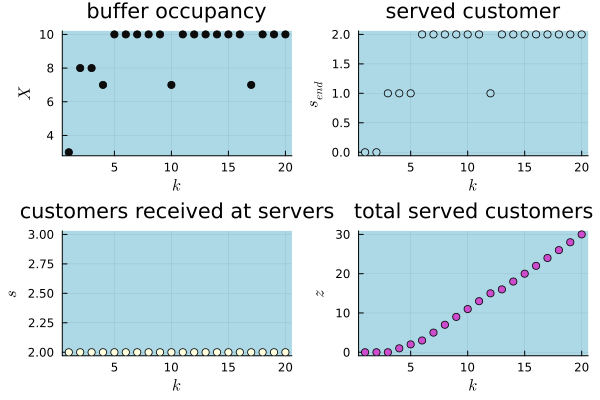

In [ ]:
evolution = [X_dl[1:horiz,1], s_end[1:horiz,1], s_dl[1:horiz,1], z_dl[1:horiz,1]]
ylabel = [L"X" L"s_{end}" L"s" L"z"]
title = ["buffer occupancy" "served customer" "customers received at servers" "total served customers"]

plotData(evolution, ylabel, title)